# Timestamp

In [1]:
# Imports
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm

tqdm.pandas(desc="Progress")

In [2]:
# Metadata
header_rows = 3
input_file = "data_1722191746.csv"
output_file = "INFLUX_" + input_file

In [23]:
df = pd.read_csv(input_file, header=header_rows, engine="pyarrow")

In [24]:
df["_time"] = pd.to_datetime(df["_time"], unit="ms")

In [ ]:
df.drop_duplicates(subset=["_time", "_field"], inplace=True)

In [27]:
data = (
    df.drop_duplicates(subset=["_time", "_field"])[["_time", "_field", "_value"]]
    .set_index(["_time", "_field"])
    .unstack()
    .droplevel(0, axis=1)
)

In [28]:
data

_field,Acc x,Acc y,Acc z,B,DHT hum,DHT temp,G,Gyro x,Gyro y,Gyro z,Humidity,Intensity,Mag x,Mag y,Mag z,PDM,Pressure,Proximity,R,Temperature
_time,,,,,,,,,,,,,,,,,,,,
2024-07-28 18:35:48.133,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.20,2.20,2.50,38.95,255.0,48.80,94.14,12.17,-45.00,1007.63,0.0,0.0,33.49
2024-07-28 18:35:48.775,-0.08,0.04,-1.01,0.0,40.8,27.3,255.0,2.14,2.26,2.38,39.15,255.0,48.62,93.79,11.96,-51.00,1007.63,0.0,0.0,33.52
2024-07-28 18:35:49.651,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.26,2.26,2.50,38.92,255.0,48.80,94.08,12.76,27.00,1007.71,0.0,0.0,33.45
2024-07-28 18:35:50.415,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.14,2.26,2.50,38.99,255.0,48.39,93.70,12.33,55.25,1007.58,0.0,0.0,33.49
2024-07-28 18:35:50.595,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.14,2.14,2.44,38.95,255.0,48.49,93.70,12.16,7.00,1007.72,0.0,0.0,33.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-28 19:52:40.000,-0.08,0.04,-1.00,0.0,41.2,26.8,255.0,2.08,2.20,2.50,38.93,255.0,48.67,92.93,12.13,-35.50,1006.61,0.0,0.0,33.32
2024-07-28 19:52:41.000,-0.08,0.04,-1.00,0.0,41.2,26.9,255.0,2.14,2.26,2.62,38.97,255.0,48.25,93.42,11.84,-13.75,1006.60,0.0,0.0,33.34
2024-07-28 19:52:42.000,-0.08,0.04,-1.00,0.0,41.2,26.9,255.0,1.95,2.20,2.44,38.88,255.0,48.49,92.52,12.52,-37.50,1006.69,0.0,0.0,33.30


# Calibration

In [10]:
temp_df = data[["Temperature", "DHT temp"]].rename(
    {"Temperature": "sense", "DHT temp": "dht"}, axis=1
)
hum_df = data[["Humidity", "DHT hum"]].rename(
    {"Humidity": "sense", "DHT hum": "dht"}, axis=1
)

## Temperature

In [11]:
group_temp_df = temp_df.groupby("dht").describe().droplevel(0, axis=1)
group_temp_df

,count,mean,std,min,25%,50%,75%,max
dht,,,,,,,,
26.8,150.0,33.443867,0.055051,33.28,33.43,33.47,33.49,33.52
26.9,1169.0,33.493439,0.061935,33.30,33.47,33.49,33.54,33.69
27.0,1037.0,33.634677,0.060340,33.43,33.60,33.65,33.67,33.78
27.1,1003.0,33.723858,0.047731,33.56,33.69,33.73,33.76,33.84
27.2,421.0,33.798409,0.025506,33.73,33.78,33.80,33.82,33.86
27.3,1613.0,33.812399,0.051140,33.45,33.80,33.82,33.84,33.89
27.4,15.0,33.574667,0.050266,33.50,33.52,33.60,33.62,33.63


### Polyfit

Polyfit: 
1.031 x - 7.637

Covariance matrix:
[[ 5.60130967e-05 -1.88657610e-03]
 [-1.88657610e-03  6.35428017e-02]]



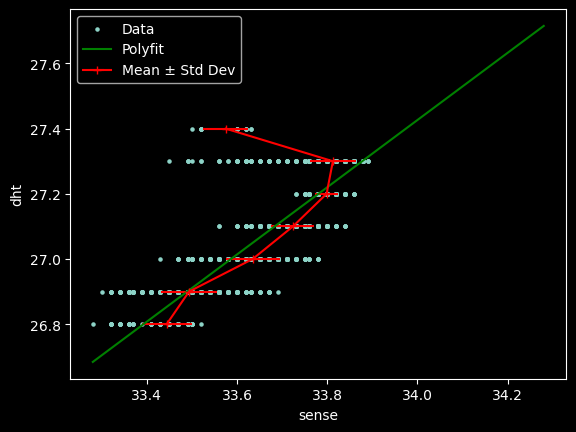

In [14]:
p_temp, cov_temp = np.polyfit(temp_df["sense"], temp_df["dht"], deg=1, cov=True)
poly_temp = np.poly1d(p_temp)

print(f"Polyfit:{poly_temp}\n")
print(f"Covariance matrix:\n{cov_temp}\n")

ax = temp_df.plot.scatter(x="sense", y="dht", marker=".", label="Data")
ax.errorbar(
    group_temp_df["mean"],
    group_temp_df.index,
    xerr=group_temp_df["std"],
    c="r",
    marker="+",
    label="Mean ± Std Dev",
)

x_temp = np.arange(temp_df["sense"].min(), temp_df["sense"].max() + 0.5, 0.5)
ax.plot(x_temp, poly_temp(x_temp), c="g", label="Polyfit")
ax.legend()

plt.show()

### Error

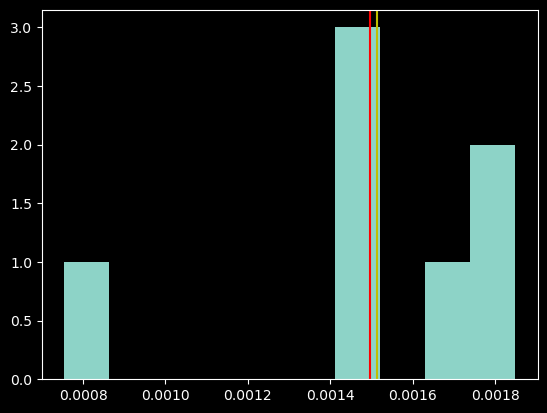

Median: 0.00151245429291748
Mean: 0.0014955430484353237


In [15]:
temp_error = group_temp_df["std"] / group_temp_df["mean"]

plt.hist(temp_error)
plt.axvline(temp_error.mean(), c="r")
plt.axvline(temp_error.median(), c="y")
plt.show()

print(f"Median: {temp_error.median()}")
print(f"Mean: {temp_error.mean()}")

## Humidity

In [16]:
group_hum_df = hum_df.groupby("dht").describe().droplevel(0, axis=1)
group_hum_df

,count,mean,std,min,25%,50%,75%,max
dht,,,,,,,,
40.6,33.0,38.854545,0.205321,38.46,38.7100,38.83,39.0300,39.28
40.7,362.0,38.839282,0.164349,38.33,38.7300,38.83,38.9400,39.28
40.8,182.0,38.957857,0.147967,38.57,38.8600,38.98,39.0600,39.34
40.9,298.0,38.955470,0.164734,38.54,38.8325,38.97,39.0775,39.39
41.0,188.0,38.972819,0.160080,38.63,38.8475,38.98,39.1000,39.43
41.1,398.0,38.918819,0.156040,38.45,38.8200,38.91,39.0100,39.50
41.2,1825.0,38.861030,0.132962,38.43,38.7700,38.86,38.9500,39.30
41.3,825.0,38.902885,0.142082,38.42,38.8000,38.90,39.0000,39.35
41.4,1009.0,38.995570,0.122916,38.60,38.9100,39.00,39.0800,39.35


### Polyfit

Polyfit: 
0.2295 x + 32.26

Covariance matrix:
[[ 3.54025342e-04 -1.37768975e-02]
 [-1.37768975e-02  5.36136122e-01]]



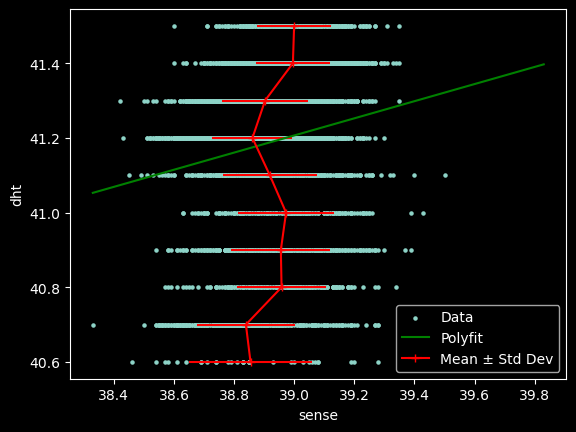

In [19]:
p_hum, cov_hum = np.polyfit(hum_df["sense"], hum_df["dht"], deg=1, cov=True)
poly_hum = np.poly1d(p_hum)

print(f"Polyfit:{poly_hum}\n")
print(f"Covariance matrix:\n{cov_hum}\n")

ax = hum_df.plot.scatter(x="sense", y="dht", marker=".", label="Data")
ax.errorbar(
    group_hum_df["mean"],
    group_hum_df.index,
    xerr=group_hum_df["std"],
    c="r",
    marker="+",
    label="Mean ± Std Dev",
)

x_hum = np.arange(hum_df["sense"].min(), hum_df["sense"].max() + 0.5, 0.5)
ax.plot(x_hum, poly_hum(x_hum), c="g", label="Polyfit")
ax.legend()

plt.show()

### Error

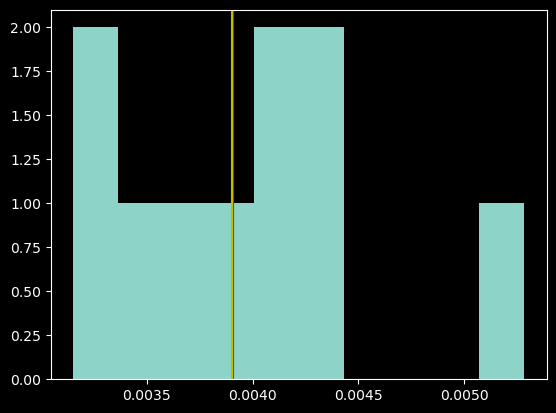

Median: 0.003903752330801766
Mean: 0.0039062481660841744


In [20]:
hum_error = group_hum_df["std"] / group_hum_df["mean"]

plt.hist(hum_error)
plt.axvline(hum_error.mean(), c="r")
plt.axvline(hum_error.median(), c="y")
plt.show()

print(f"Median: {hum_error.median()}")
print(f"Mean: {hum_error.mean()}")